# 1、初始化模型

In [1]:
from langchain_openai import ChatOpenAI
import os, dotenv

dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_BASE_URL"] = os.getenv("OPENAI_BASE_URL")

llm = ChatOpenAI(model="gpt-5-mini")

# 2、LLM功能增强
给大模型添加工具调用、结构化输出、记忆能力等

In [5]:
# Schema for structured output
from pydantic import BaseModel, Field


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[]

# 3、提示链（PromptChaining）
在LangGraph框架中，Prompt Chaining（提示链） 是一种将复杂任务拆解为多个连续步骤的设计模式，其中前一步大语言模型（LLM）的输出，会作为下一步的输入。



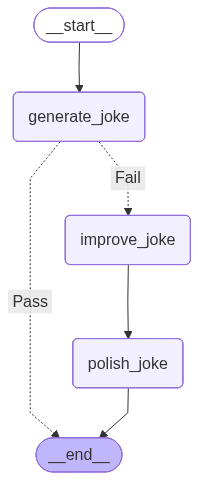

初始的笑话:
疯狂动物城一家快餐店推出了两个新套餐：  
“食肉者套餐”和“素食者套餐”。一只羊大胆地点了食肉者套餐，收银员惊讶地问：“你确定要吃肉吗？”  
羊淡定地说：“当然——我的朋友是狮子，他请客。”

--- --- ---

final_joke:
疯狂动物城一家快餐店推出了两个新套餐：  
“食肉者套餐”和“素食者套餐”。一只羊大胆地点了食肉者套餐，收银员惊讶地问：“你确定要吃肉吗？”  
羊淡定地说：“当然——我的朋友是狮子，他请客。”


In [10]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 定义Graph状态数据结构
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str


# 定义节点
def generate_joke(state: State):
    """第一次LLM调用，生成初始的笑话"""

    msg = llm.invoke(f"编写一个关于{state["topic"]}主题的笑话")
    return {"joke": msg.content}


def check_punchline(state: State):
    """检查笑话是否具备笑点"""

    # 这里做简单的检查：判断笑话中是否包含？或者！
    if "？" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    else:
        return "Fail"


def improve_joke(state: State):
    """第二次LLM调用来改善笑话"""

    msg = llm.invoke(f"通过添加“谐音梗“来让下面这个笑话更加有趣一些\n笑话: {state["joke"]}")
    return {"improved_joke": msg.content}

def polish_joke(state:State):
    """第三次LLM调用来获取最终的笑话"""

    msg = llm.invoke(f"给当前这个笑话添加一个让人感到惊奇的转折\n笑话: {state["improved_joke"]}")
    return {"final_joke": msg.content}

# 构建工作流
workflow = StateGraph(State)

# 添加节点
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# 添加边，连接这些节点
workflow.add_edge(START, "generate_joke")
# 添加条件边，根据不同条件跳转到不同节点
workflow.add_conditional_edges("generate_joke", check_punchline, {"Pass": END, "Fail": "improve_joke"})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# 编译图
chain = workflow.compile()

# 展示工作流
display(Image(chain.get_graph().draw_mermaid_png()))

# 调用结果
state = chain.invoke({"topic": "疯狂动物城"})
print(f"初始的笑话:\n{state["joke"]}")
print("\n--- --- ---\n")
if "improve_joke" in state:
    print(f"improved_joke:\n{state["improved_joke"]}")
    print("\n--- --- ---\n")
    print(f"final_joke:\n{state["final_joke"]}")
else:
    print(f"final_joke:\n{state["joke"]}")



# 7、评估期-优化器
在评估期-优化器工作流中，一个LLM调用会生成响应，而另一个LLM调用则是用来评估这个响应的质量是否满足预期标准，如果满足，则流程结束；如果不满足，则会生成反馈，并重新调用第一个LLM以改进响应。

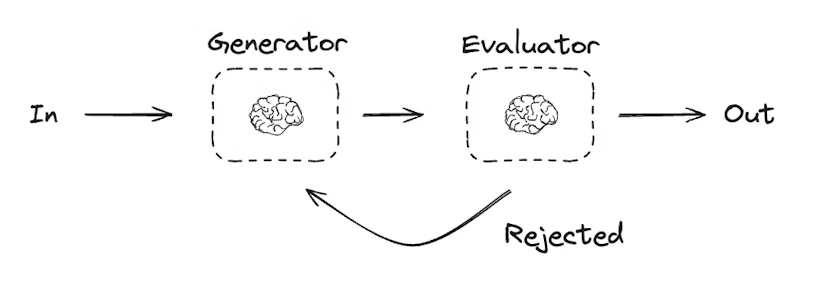

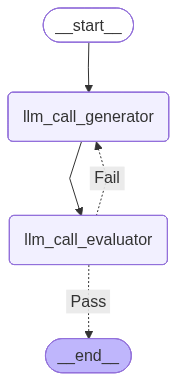

笑话来啦：
示例1（单句，紧凑反差）：
朱迪：‘快！有人偷了我的胡萝卜蛋糕！’  
树獭慢吞吞在电脑上点点：‘好的，已为此案预约——两年后周三，下午三点半。请自备保鲜膜。’

示例2（对话＋反转，节拍短促，带时间标记）：
朱迪：‘有人偷了我的蛋糕！’  
树獭接线员（极慢）：‘请……把……案……情……从……头……说……一……遍……’  
朱迪把电话递给尼克：‘你去重演，我去找蛋糕。’  
（十分钟后）  
朱迪回来，桌上只剩盘底。树獭擦嘴：‘抱歉，我们那会儿在排队午休，证据当时刚好轮到点心时间。’


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from pydantic import BaseModel, Field
from textwrap import dedent


# 定义Graph State
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# 定义评估的数据结构
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="判定这个笑话是否有趣，可选项：【funny、not funny】"
    )
    feedback: str = Field(
        description="如果这个笑话不有趣（not funny），需要提供如何改进这个笑话的反馈"
    )


# 给模型添加结构化输出能力
evaluator = llm.with_structured_output(Feedback)


# 定义节点
# 节点1：生成器
def llm_call_generator(state: State):
    """LLM调用生成一个笑话，或改进这个笑话"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"编写一个关于{state['topic']}主题的笑话，但需要考虑如下建议: \n{state['feedback']}"
        )
    else:
        msg = llm.invoke(f"编写一个关于{state['topic']}主题的笑话")

    return {"joke": msg.content}


# 节点2：评估器
def llm_call_evaluator(state: State):
    """评估笑话是否好笑，并给出建议"""

    evaluate_prompt = dedent(
    f"""
    评估下面这个笑话是否有趣？如果不有趣（not funny），给出改进的建议。
    笑话：{state.get('joke')}
    """
    )
    result = evaluator.invoke(evaluate_prompt)
    return {"funny_or_not": result.grade, "feedback": result.feedback}

# 路由逻辑
def route_joke(state:State):
    """根据评估结果决定路由逻辑"""
    if state['funny_or_not'] == "funny":
        return "Pass"
    elif state["funny_or_not"] == "not funny":
        return "Fail"

# 定义工作流
optimizer_builder =  StateGraph(State)

# 添加节点
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# 添加边
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges("llm_call_evaluator", route_joke, {"Pass": END, "Fail": "llm_call_generator"})

# 编译图
app = optimizer_builder.compile()
# 展示图的结构
display(Image(app.get_graph().draw_mermaid_png()))
# 调用
state = app.invoke({"topic": "疯狂动物城"})
print(f"笑话来啦：\n{state['joke']}")

# 8、Agents
智能体(Agents)通常被实现为一个使用工具执行操作的LLM，他们在持续反馈循环中运行，通常用于问题和解决方案不可知的情况。Agent比工作流拥有更高的自主性，可以自主决定使用哪些工具，以及如何解决问题。

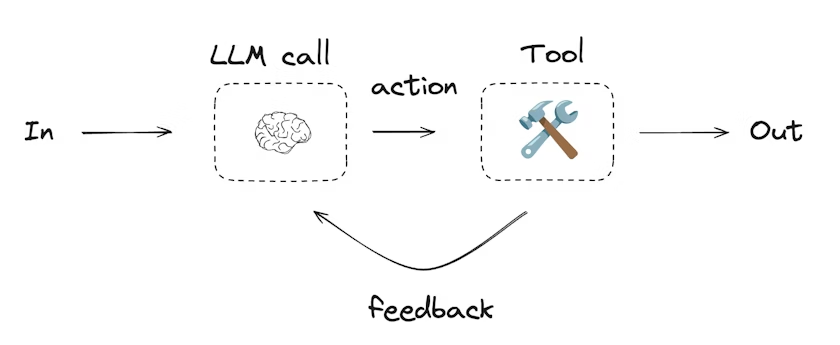

In [2]:
from langchain.tools import tool


# 定义工具
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# 增强LLM
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

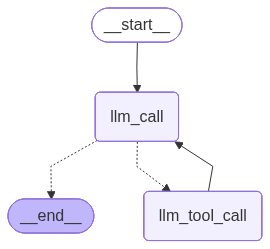

================================ Human Message =================================

使用工具计算 3+23=?
================================== Ai Message ==================================
Tool Calls:
  add (call_IwmEABN7GYU8fc95EbPmSiDT)
 Call ID: call_IwmEABN7GYU8fc95EbPmSiDT
  Args:
    a: 3
    b: 23
================================= Tool Message =================================

26
================================== Ai Message ==================================

3 + 23 = 26


In [6]:
from langgraph.graph import MessagesState
from langchain.messages import SystemMessage, HumanMessage, ToolMessage

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal


# 定义节点
# 节点1：模型自己决定是否调用工具
def llm_call(state: MessagesState):
    """模型自行决定是否要调用工具"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="你是一个有用的算数助手，可以使用工具来帮助用户解决一些计算相关问题"
                    )
                ]
                + state["messages"]
            )
        ]
    }

# 节点2：工具调用
def llm_tool_call(state: MessagesState):
    """调用工具"""

    latest_message = state["messages"][-1]
    result = []
    for tool_call in latest_message.tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observatopn = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observatopn, tool_call_id=tool_call['id']))
        
    return {"messages": result}

def should_continue(state: MessagesState)-> Literal["llm_tool_call", END]:
    """判断流程是否继续"""

    latest_message = state["messages"][-1]
    if latest_message.tool_calls:
        return "llm_tool_call"
    else:
        return END

# 定义工作流
agent_builder = StateGraph(MessagesState)
# 添加节点
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("llm_tool_call", llm_tool_call)
# 添加边
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, ["llm_tool_call", END])
agent_builder.add_edge("llm_tool_call", "llm_call") # 工具调用后，召回结果返回给llm进行下一步决定
# 编译图
app = agent_builder.compile()
# 展示图的结构
display(Image(app.get_graph(xray=True).draw_mermaid_png()))
# 调用
messages = [HumanMessage(content="使用工具计算 3+23=?")]
response = app.invoke({"messages": messages})
for message in response["messages"]:
    message.pretty_print()
    
